In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import time
import requests
from math import isnan
import geohash2
import json

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("../swift_logistics.csv")
data.head()

,Booking ID,Booking Date,Trip Start Date,Planned ETA,Actual ETA,Trip End Date,Origin Location,Origin Lat,Origin Lon,Stopover Location,...,Supplier Specialization,Driver Name,Driver Mobile No,Trip Status,Load Type,Delivery Window Start,Delivery Window End,Driver Hours Logged,Notes,Trip Type
0,be4f18ec-07e3-47f8-a99a-5a6a17666e1a,2021-12-14,2021-12-15 09:00:00.000000,2021-12-22 09:03:22.626207,2021-12-21 18:34:37.114674,2021-12-21 22:05:53.450264,"Seattle, WA",47.6062,-122.3321,"Boston, MA",...,Perishables,Samantha Jones,(849)694-7174,Completed,Less-than-Truckload,2021-12-22 08:00:00,2021-12-22 18:00:00,157.10,NaN,Regular
1,c5bfb8b2-e807-46a0-9623-f128e6266ad1,2021-12-14,2021-12-22 08:08:25.087927,2021-12-24 02:45:15.533920,2021-12-24 04:13:03.248529,2021-12-24 04:13:03.248529,"San Antonio, TX",29.4241,-98.4936,NaN,...,NaN,Samantha Jones,(849)694-7174,Completed,NaN,2021-12-24 08:00:00,2021-12-24 18:00:00,44.08,Empty Return,Empty Return
2,fe2da979-6b92-48d0-9fca-35bb4f02d560,2023-03-10,2023-03-11 05:00:00.000000,2023-03-11 15:27:21.442957,2023-03-11 15:23:55.702556,2023-03-11 20:45:09.592338,"New York, NY",40.7128,-74.0060,NaN,...,Hazardous,Joseph Dean,570.434.8247x7109,Completed,Less-than-Truckload,2023-03-11 08:00:00,2023-03-11 18:00:00,15.75,NaN,Regular
3,4677714d-607a-4cc4-8f31-11da924d0c82,2023-03-10,2023-03-12 08:37:33.550425,2023-03-12 13:25:08.441068,2023-03-12 13:45:56.565080,2023-03-12 13:45:56.565080,"Washington, DC",38.9072,-77.0369,NaN,...,NaN,Joseph Dean,570.434.8247x7109,Completed,NaN,2023-03-12 08:00:00,2023-03-12 18:00:00,5.14,Empty Return,Empty Return
4,d9cb5647-f333-4674-8d49-bdb824f57664,2021-10-15,2021-10-15 13:00:00.000000,2021-10-15 13:52:49.005732,2021-10-16 00:48:30.263506,2021-10-16 03:22:43.194875,"San Diego, CA",32.7157,-117.1611,NaN,...,Agriculture,Stacy Freeman,+1-309-313-4316,Completed,Full Truckload,2021-10-15 08:00:00,2021-10-15 18:00:00,14.38,NaN,Regular


# DATA CLEANING

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14316 entries, 0 to 14315
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Booking ID               14316 non-null  object 
 1   Booking Date             14316 non-null  object 
 2   Trip Start Date          14316 non-null  object 
 3   Planned ETA              14316 non-null  object 
 4   Actual ETA               12868 non-null  object 
 5   Trip End Date            12868 non-null  object 
 6   Origin Location          14316 non-null  object 
 7   Origin Lat               14316 non-null  float64
 8   Origin Lon               14316 non-null  float64
 9   Stopover Location        1547 non-null   object 
 10  Stopover Lat             1547 non-null   float64
 11  Stopover Lon             1547 non-null   float64
 12  Destination Location     14316 non-null  object 
 13  Destination Lat          14316 non-null  float64
 14  Destination Lon       

In [4]:
# making date columns date type 
for col in data.columns: 
    if col.__contains__('Date') or col.__contains__('ETA') or col.__contains__('Delivery Window'):
        data[col] = pd.to_datetime(data[col])
        print(f"{col}: {data[col].dtype}")

Booking Date: datetime64[ns]
Trip Start Date: datetime64[ns]
Planned ETA: datetime64[ns]
Actual ETA: datetime64[ns]
Trip End Date: datetime64[ns]
Delivery Window Start: datetime64[ns]
Delivery Window End: datetime64[ns]


In [5]:
data.isna().sum()

Booking ID                     0
Booking Date                   0
Trip Start Date                0
Planned ETA                    0
Actual ETA                  1448
Trip End Date               1448
Origin Location                0
Origin Lat                     0
Origin Lon                     0
Stopover Location          12769
Stopover Lat               12769
Stopover Lon               12769
Destination Location           0
Destination Lat                0
Destination Lon                0
Distance (KM)                  0
Shipment Type                  0
Material Category           3258
Material Shipped            4206
Material Weight (KG)        4206
Vehicle Type                   0
Vehicle Registration           0
GPS Notes                      0
Enroute Issues             12391
Supplier Name               3258
Customer Name               3258
Supplier Specialization     3258
Driver Name                    0
Driver Mobile No               0
Trip Status                    0
Load Type 

In [6]:
# understanding why actual eta has null values : possible explanations, cancelled trips 
print(data[(data['Actual ETA'].isna()) & (data['Trip Status'] == 'Cancelled')].shape[0])
print(data[(data['Trip End Date'].isna()) & (data['Trip Status'] == 'Cancelled')].shape[0])

1448
1448


All the missing Actual ETA  and Trip End Date were due to trips being cancelled, it makes sense for stopover location to have null values due the fact that not all trips are meant to have stopovers. 

It is questionable for a trip to have empty Material Shipped. This might be due to illegal transit or data entry error.

In [7]:
data[['Material Category', 'Material Shipped', 'Material Weight (KG)']][
    (data['Material Category'].isna()) & 
    ~(data['Material Shipped'].isna())
]

,Material Category,Material Shipped,Material Weight (KG)


In [8]:
data[['Material Category', 'Material Shipped', 'Material Weight (KG)']][
    (data['Material Category'].isna()) & 
    ~(data['Material Weight (KG)'].isna())
]

,Material Category,Material Shipped,Material Weight (KG)


In [9]:
data[data['Material Category'].isna()]

,Booking ID,Booking Date,Trip Start Date,Planned ETA,Actual ETA,Trip End Date,Origin Location,Origin Lat,Origin Lon,Stopover Location,...,Supplier Specialization,Driver Name,Driver Mobile No,Trip Status,Load Type,Delivery Window Start,Delivery Window End,Driver Hours Logged,Notes,Trip Type
1,c5bfb8b2-e807-46a0-9623-f128e6266ad1,2021-12-14,2021-12-22 08:08:25.087927,2021-12-24 02:45:15.533920,2021-12-24 04:13:03.248529,2021-12-24 04:13:03.248529,"San Antonio, TX",29.424100,-98.493600,NaN,...,NaN,Samantha Jones,(849)694-7174,Completed,NaN,2021-12-24 08:00:00,2021-12-24 18:00:00,44.08,Empty Return,Empty Return
3,4677714d-607a-4cc4-8f31-11da924d0c82,2023-03-10,2023-03-12 08:37:33.550425,2023-03-12 13:25:08.441068,2023-03-12 13:45:56.565080,2023-03-12 13:45:56.565080,"Washington, DC",38.907200,-77.036900,NaN,...,NaN,Joseph Dean,570.434.8247x7109,Completed,NaN,2023-03-12 08:00:00,2023-03-12 18:00:00,5.14,Empty Return,Empty Return
5,37592c10-d60e-4f90-9e72-15b318c8ffe6,2021-10-15,2021-10-16 07:50:47.513685,2021-10-16 08:11:23.571965,2021-10-16 08:09:32.361907,2021-10-16 08:09:32.361907,Tijuana,32.514947,-117.038247,NaN,...,NaN,Stacy Freeman,+1-309-313-4316,Completed,NaN,2021-10-16 08:00:00,2021-10-16 18:00:00,0.31,Empty Return,Empty Return
7,ca7672ac-0023-4b0f-a7b7-4e0e27c232a5,2024-05-06,2024-05-16 11:13:05.910220,2024-05-18 07:58:03.164849,2024-05-18 10:57:16.244036,2024-05-18 10:57:16.244036,"Vancouver, BC",49.282729,-123.120738,NaN,...,NaN,Wanda Torres,+1-309-413-3412x328,Completed,NaN,2024-05-18 08:00:00,2024-05-18 18:00:00,47.74,Empty Return,Empty Return
9,8fe96b3b-bae9-47b7-a5dc-b07339fdd206,2022-05-24,2022-05-28 12:57:19.483451,2022-05-29 12:38:39.376927,2022-05-29 14:27:33.631409,2022-05-29 14:27:33.631409,"San Jose, CA",37.338200,-121.886300,NaN,...,NaN,Tony Huerta,664-674-3671x3695,Completed,NaN,2022-05-29 08:00:00,2022-05-29 18:00:00,25.50,Empty Return,Empty Return
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14286,7e5a3d22-2eb3-4c23-84b9-344a408c06ce,2020-11-04,2020-11-08 01:23:30.296110,2020-11-08 21:09:33.241713,2020-11-08 19:30:48.377542,2020-11-08 19:30:48.377542,"San Diego, CA",32.715700,-117.161100,NaN,...,NaN,Stephen Gilmore,(408)834-8124,Completed,NaN,2020-11-08 08:00:00,2020-11-08 18:00:00,18.12,Empty Return,Empty Return
14290,7803cd62-5548-4838-b806-cb55575d0a7f,2022-01-28,2022-02-02 10:14:05.176218,2022-02-03 14:37:43.026039,2022-02-03 15:40:18.911391,2022-02-03 15:40:18.911391,"Fort Worth, TX",32.755500,-97.330800,NaN,...,NaN,Pamela Thompson,474.729.6717x56551,Completed,NaN,2022-02-03 08:00:00,2022-02-03 18:00:00,29.44,Empty Return,Empty Return
14294,bafe8b17-2026-4186-b977-7d0fcd5ea459,2024-09-27,2024-09-29 03:10:29.283810,2024-09-29 22:16:51.277653,2024-09-30 00:03:56.963871,2024-09-30 00:03:56.963871,"Phoenix, AZ",33.448400,-112.074000,NaN,...,NaN,William Cardenas,001-624-404-1574x73384,Completed,NaN,2024-09-29 08:00:00,2024-09-29 18:00:00,20.89,Empty Return,Empty Return
14303,66240aff-a86c-4079-9dc8-581176a81571,2019-11-04,2019-11-07 06:31:36.905553,2019-11-07 23:38:14.909879,2019-11-08 00:39:33.368266,2019-11-08 00:39:33.368266,"Dallas, TX",32.776700,-96.797000,NaN,...,NaN,John Jones,(449)631-6459,Completed,NaN,2019-11-07 08:00:00,2019-11-07 18:00:00,18.13,Empty Return,Empty Return


It seems as if most of the trips with the empty material category are the ones with empty return trips

We are not going to delete the empty return trips as they can shape our understanding of the role of the suppliers in delaying the shipment. It isolates traffic, drivers issues and route inefficiences on their own and even the miscalculations of estimated time of arrival. There are no documentations asked to mention a few. 

In [10]:
data[['Trip Type', 'Enroute Issues']][(data['Trip Type'] == 'Empty Return') & ~(data['Enroute Issues'].isna())].value_counts()

Trip Type     Enroute Issues
Empty Return  Route Delay       112
Name: count, dtype: int64

Already we can see the issue issues like congestion along this roads before we do the analysi. Perhaps it was a daily thing but it highlight some of the issues Swift Logistics might be facing. 
For now we can just state either the delays were heavy or the Planned ETA's calculations need a revisit

In [11]:
data[(data['Trip Type'] != 'Empty Return') & (data['Material Category'].isna())]

,Booking ID,Booking Date,Trip Start Date,Planned ETA,Actual ETA,Trip End Date,Origin Location,Origin Lat,Origin Lon,Stopover Location,...,Supplier Specialization,Driver Name,Driver Mobile No,Trip Status,Load Type,Delivery Window Start,Delivery Window End,Driver Hours Logged,Notes,Trip Type


In [12]:
data[(data['Trip Type'] != 'Empty Return') & (data['Material Shipped'].isna())]

,Booking ID,Booking Date,Trip Start Date,Planned ETA,Actual ETA,Trip End Date,Origin Location,Origin Lat,Origin Lon,Stopover Location,...,Supplier Specialization,Driver Name,Driver Mobile No,Trip Status,Load Type,Delivery Window Start,Delivery Window End,Driver Hours Logged,Notes,Trip Type
28,c823fe11-d44e-4b8c-b587-941aecfd6fef,2022-02-13,2022-02-13 12:00:00.000000,2022-02-16 01:30:07.874583,NaT,NaT,"Indianapolis, IN",39.768400,-86.158100,"Jacksonville, FL",...,Scammer,Alexis Baker,(368)911-7758,Cancelled,Less-than-Truckload,2022-02-16 08:00:00,2022-02-16 18:00:00,0.0,Booking Cancelled – No Show,Regular
33,917875c8-0397-4fcc-a6e8-336474feef3c,2024-12-25,2024-12-26 01:00:00.000000,2025-01-01 15:23:12.443530,NaT,NaT,"Los Angeles, CA",34.052200,-118.243700,"Boston, MA",...,Scammer,Donald Schultz,+1-856-398-4789,Cancelled,Full Truckload,2025-01-01 08:00:00,2025-01-01 18:00:00,0.0,Booking Cancelled – No Show,Regular
65,f34a17e0-9a5d-4fdd-9718-19be8f8e4be9,2019-08-15,2019-08-27 01:33:27.945442,2019-08-29 08:11:14.653095,NaT,NaT,"Seattle, WA",47.606200,-122.332100,NaN,...,Scammer,Pamela Thompson,474.729.6717x56551,Cancelled,Less-than-Truckload,2019-08-29 08:00:00,2019-08-29 18:00:00,0.0,Booking Cancelled – No Show,Continuation
77,133e97d4-0002-42ae-ae15-14a5f94c8e2a,2020-04-04,2020-04-04 04:00:00.000000,2020-04-06 07:09:15.927062,NaT,NaT,Tijuana,32.514947,-117.038247,NaN,...,Scammer,Jon Bates,(980)871-5451x6808,Cancelled,Full Truckload,2020-04-06 08:00:00,2020-04-06 18:00:00,0.0,Booking Cancelled – No Show,Regular
87,e7cbb3c2-04f5-458a-abd1-dc00df942212,2021-07-14,2021-07-14 20:00:00.000000,2021-07-16 03:01:52.146471,NaT,NaT,"Fort Worth, TX",32.755500,-97.330800,NaN,...,Scammer,Alexis Herrera,754.596.5137x098,Cancelled,Full Truckload,2021-07-16 08:00:00,2021-07-16 18:00:00,0.0,Booking Cancelled – No Show,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14225,746f531b-484a-4ba0-81e9-5536a3cf36b6,2019-07-04,2019-07-08 03:30:29.888535,2019-07-10 16:28:20.742004,NaT,NaT,Tijuana,32.514947,-117.038247,NaN,...,Scammer,Tyrone Fox,+1-939-503-9799,Cancelled,Full Truckload,2019-07-10 08:00:00,2019-07-10 18:00:00,0.0,Booking Cancelled – No Show,Continuation
14264,0704f269-ed89-4dd6-9981-098646c2733c,2020-12-02,2020-12-02 02:00:00.000000,2020-12-07 17:52:10.796786,NaT,NaT,"New York, NY",40.712800,-74.006000,NaN,...,Scammer,Tyrone Fox,+1-939-503-9799,Cancelled,Less-than-Truckload,2020-12-07 08:00:00,2020-12-07 18:00:00,0.0,Booking Cancelled – No Show,Regular
14279,b2255c2a-4016-4f34-9016-c9f678cf492f,2021-04-06,2021-04-06 16:00:00.000000,2021-04-09 19:08:15.388231,NaT,NaT,"Los Angeles, CA",34.052200,-118.243700,NaN,...,Scammer,James Goodman,+1-864-349-4363x2705,Cancelled,Full Truckload,2021-04-09 08:00:00,2021-04-09 18:00:00,0.0,Booking Cancelled – No Show,Regular
14283,5fc6b879-24e2-4bed-ba30-16eea80225cf,2024-06-21,2024-06-21 07:00:00.000000,2024-06-28 06:04:35.692010,NaT,NaT,"Charlotte, NC",35.227100,-80.843100,"Philadelphia, PA",...,Scammer,Michael Berger,8504455623,Cancelled,Full Truckload,2024-06-28 08:00:00,2024-06-28 18:00:00,0.0,Booking Cancelled – No Show,Regular


It seems as if it is not an empty return then it is a scammer issue that is causing na in the Material Shipped category contrary to the initial hypothesis of illegal possession in transit.

In [13]:
empty = data[(data['Trip Type'] == 'Empty Return') & (data['Material Shipped'].isna())]
scammer = data[(data['Supplier Specialization'] == 'Scammer') & (data['Material Shipped'].isna())]

print(f"Empty returns: {empty.shape[0]} + Scammer trips: {scammer.shape[0]} = {empty.shape[0] + scammer.shape[0]} nulls in Material shipped explained")

Empty returns: 3258 + Scammer trips: 948 = 4206 nulls in Material shipped explained


For enroute issues it is understandable for some rows to be null as it highlights that not all trips had issues.
Supplier Name               3324
Customer Name               3324
Supplier Specialization     3324
Driver Name                    0
Driver Mobile No               0
Trip Status                    0
Load Type                   3324
Delivery Window Start          0
Delivery Window End            0
Driver Hours Logged            0
Notes                       9988
Trip Type                      0

In [14]:
data =  data[~(data['Supplier Specialization'] == 'Scammer')]
data.isna().sum()

Booking ID                     0
Booking Date                   0
Trip Start Date                0
Planned ETA                    0
Actual ETA                   500
Trip End Date                500
Origin Location                0
Origin Lat                     0
Origin Lon                     0
Stopover Location          11963
Stopover Lat               11963
Stopover Lon               11963
Destination Location           0
Destination Lat                0
Destination Lon                0
Distance (KM)                  0
Shipment Type                  0
Material Category           3258
Material Shipped            3258
Material Weight (KG)        3258
Vehicle Type                   0
Vehicle Registration           0
GPS Notes                      0
Enroute Issues             11607
Supplier Name               3258
Customer Name               3258
Supplier Specialization     3258
Driver Name                    0
Driver Mobile No               0
Trip Status                    0
Load Type 

In [15]:
print(data[(data['Supplier Name'].isna()) & (data['Trip Type'] == 'Empty Return')].shape[0])
print(data[(data['Customer Name'].isna()) & (data['Trip Type'] == 'Empty Return')].shape[0])

3258
3258


In [16]:
print(data[(data['Load Type'].isna()) & (data['Trip Type'] == 'Empty Return')].shape[0])

3258


All null values have been explained

### Checkpoint 1

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13368 entries, 0 to 14315
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Booking ID               13368 non-null  object        
 1   Booking Date             13368 non-null  datetime64[ns]
 2   Trip Start Date          13368 non-null  datetime64[ns]
 3   Planned ETA              13368 non-null  datetime64[ns]
 4   Actual ETA               12868 non-null  datetime64[ns]
 5   Trip End Date            12868 non-null  datetime64[ns]
 6   Origin Location          13368 non-null  object        
 7   Origin Lat               13368 non-null  float64       
 8   Origin Lon               13368 non-null  float64       
 9   Stopover Location        1405 non-null   object        
 10  Stopover Lat             1405 non-null   float64       
 11  Stopover Lon             1405 non-null   float64       
 12  Destination Location     13368 non-nu

In [18]:
data.duplicated().sum()

0

In [19]:
# are the scenarios of repeated booking id
data['Booking ID'].nunique()

13368

In [20]:
# case where trip start date is less than booking id or trip end date is less than actual eta 
data[data['Trip Start Date'] < data['Booking Date']].shape[0]

0

In [21]:
# case where trip start date is less than booking id or trip end date is less than actual eta 
data[data['Trip End Date'] < data['Actual ETA']].shape[0]

0

In [22]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Booking Date,13368,2021-12-20 13:31:59.569120512,2019-01-01 00:00:00,2020-06-26 00:00:00,2021-12-20 00:00:00,2023-06-05 00:00:00,2024-12-31 00:00:00,NaN
Trip Start Date,13368,2021-12-23 08:59:46.314117632,2019-01-01 10:00:00,2020-06-28 21:44:46.372062464,2021-12-21 21:36:16.724879616,2023-06-08 10:19:39.091315456,2025-01-05 07:41:48.268266,NaN
Planned ETA,13368,2021-12-25 16:25:22.490507520,2019-01-03 06:25:54.799413,2020-07-01 04:03:09.468186880,2021-12-24 07:23:04.106908160,2023-06-10 11:20:24.846449408,2025-01-06 14:16:58.738268,NaN
Actual ETA,12868,2021-12-24 23:49:43.189678848,2019-01-03 09:56:56.584916,2020-06-30 16:06:51.523672320,2021-12-22 21:54:06.561648896,2023-06-09 01:06:05.394120960,2025-01-06 12:34:43.472822,NaN
Trip End Date,12868,2021-12-25 01:53:53.313366016,2019-01-03 12:28:59.411706,2020-06-30 17:17:05.497782784,2021-12-22 21:55:16.492738048,2023-06-09 05:16:09.913318144,2025-01-06 14:46:16.404897,NaN
Origin Lat,13368.0,35.330599,19.432608,30.2672,34.0522,40.7128,51.044733,8.376037
Origin Lon,13368.0,-96.671407,-123.120738,-112.074,-97.3308,-81.6557,-71.0589,16.19628
Stopover Lat,1405.0,35.09145,19.432608,29.7604,34.0522,40.7128,51.044733,8.336854
Stopover Lon,1405.0,-96.294762,-123.120738,-104.9903,-97.3308,-81.6557,-71.0589,15.908597
Destination Lat,13368.0,35.236587,19.432608,30.2672,34.0522,40.7128,51.044733,8.337775


In [23]:
# distance == 0 then the trip was either cancelled or scammer but we removed the scammer trips already 
data[(data['Distance (KM)'] == 0.00) & (data['Trip Status'] != 'Cancelled')].shape[0]

9

In [24]:
data[(data['Distance (KM)'] == 0.00) & (data['Trip Status'] != 'Cancelled')]

,Booking ID,Booking Date,Trip Start Date,Planned ETA,Actual ETA,Trip End Date,Origin Location,Origin Lat,Origin Lon,Stopover Location,...,Supplier Specialization,Driver Name,Driver Mobile No,Trip Status,Load Type,Delivery Window Start,Delivery Window End,Driver Hours Logged,Notes,Trip Type
606,02dc2d2d-663b-403c-b632-a572333df86f,2019-07-29,2019-07-30 23:20:29.719616,2019-07-30 23:20:29.719616,2019-07-30 23:26:29.719616,2019-07-30 23:26:29.719616,"San Diego, CA",32.715700,-117.161100,NaN,...,NaN,Stacy Freeman,+1-309-313-4316,Completed,NaN,2019-07-30 08:00:00,2019-07-30 18:00:00,0.10,Empty Return,Empty Return
2458,824e4f7b-69b0-4bd9-bc2d-da5a54e37dae,2019-06-07,2019-06-09 07:06:06.298038,2019-06-09 07:06:06.298038,2019-06-09 07:12:06.298038,2019-06-09 07:12:06.298038,Tijuana,32.514947,-117.038247,NaN,...,NaN,Samantha Jones,(849)694-7174,Completed,NaN,2019-06-09 08:00:00,2019-06-09 18:00:00,0.10,Empty Return,Empty Return
6320,52b1216d-6f94-4ba6-8868-86054de8feb0,2020-01-28,2020-01-31 20:24:42.540810,2020-01-31 20:24:42.540810,2020-01-31 21:27:45.828622,2020-01-31 21:27:45.828622,"Fort Worth, TX",32.755500,-97.330800,NaN,...,NaN,Stacy Freeman,+1-309-313-4316,Completed,NaN,2020-01-31 08:00:00,2020-01-31 18:00:00,1.05,Empty Return,Empty Return
9930,a7053f25-2fe6-4306-92fb-fe282d72dee7,2020-12-28,2020-12-30 11:15:00.738296,2020-12-30 11:15:00.738296,2020-12-30 11:21:00.738296,2020-12-30 11:21:00.738296,"Fort Worth, TX",32.755500,-97.330800,NaN,...,NaN,Shaun Wood,261-930-8730x8972,Completed,NaN,2020-12-30 08:00:00,2020-12-30 18:00:00,0.10,Empty Return,Empty Return
11282,a73eb339-2c97-4e6a-aa09-d9921c88f75d,2019-02-04,2019-02-04 16:39:41.056266,2019-02-04 16:39:41.056266,2019-02-04 16:45:41.056266,2019-02-04 16:45:41.056266,"San Diego, CA",32.715700,-117.161100,NaN,...,NaN,Nathaniel Gomez,932.797.0493,Completed,NaN,2019-02-04 08:00:00,2019-02-04 18:00:00,0.10,Empty Return,Empty Return
12411,1dbe9912-7f83-4617-b13f-97c6f644bc60,2020-08-09,2020-08-13 09:37:01.058677,2020-08-13 09:37:01.058677,2020-08-13 09:43:01.058677,2020-08-13 09:43:01.058677,"Dallas, TX",32.776700,-96.797000,NaN,...,NaN,Matthew Robinson,+1-530-310-0090x899,Completed,NaN,2020-08-13 08:00:00,2020-08-13 18:00:00,0.10,Empty Return,Empty Return
13341,90f96a37-0e2c-4f1c-9da3-835645313b7b,2022-01-14,2022-01-15 11:04:04.282990,2022-01-15 11:04:04.282990,2022-01-15 11:10:04.282990,2022-01-15 11:10:04.282990,Tijuana,32.514947,-117.038247,NaN,...,NaN,Stephen Gilmore,(408)834-8124,Completed,NaN,2022-01-15 08:00:00,2022-01-15 18:00:00,0.10,Empty Return,Empty Return
13345,f401ee16-a274-44c8-9ea5-8d1f9112dd85,2019-09-04,2019-09-05 02:26:59.320924,2019-09-05 02:26:59.320924,2019-09-05 02:32:59.320924,2019-09-05 02:32:59.320924,"Fort Worth, TX",32.755500,-97.330800,NaN,...,NaN,Stephen Gilmore,(408)834-8124,Completed,NaN,2019-09-05 08:00:00,2019-09-05 18:00:00,0.10,Empty Return,Empty Return
13483,9a910395-558d-4f6b-a6a7-60507596c3df,2021-08-09,2021-08-10 12:15:07.493563,2021-08-10 12:15:07.493563,2021-08-10 12:21:07.493563,2021-08-10 12:21:07.493563,"Dallas, TX",32.776700,-96.797000,NaN,...,NaN,Jacqueline Wolfe,001-522-780-5883x774,Completed,NaN,2021-08-10 08:00:00,2021-08-10 18:00:00,0.10,Empty Return,Empty Return


In [25]:
print(data.shape[0])
data = data[~((data['Distance (KM)'] == 0.00) & (data['Trip Type'] == 'Empty Return'))]
print(data.shape[0])

13368
13359


In [26]:
# we also have to remove the cancelled trips as they do not help  us in our analysis 
print(data.shape[0])
data = data[~(data['Trip Status'] == 'Cancelled')]
print(data.shape[0])

13359
12859


In [27]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Booking Date,12859,2021-12-20 05:56:26.670814208,2019-01-01 00:00:00,2020-06-26 00:00:00,2021-12-19 00:00:00,2023-06-04 00:00:00,2024-12-31 00:00:00,NaN
Trip Start Date,12859,2021-12-23 02:02:41.119054080,2019-01-01 10:00:00,2020-06-28 16:59:32.744125184,2021-12-20 17:00:00,2023-06-06 23:00:00,2025-01-05 07:41:48.268266,NaN
Planned ETA,12859,2021-12-25 09:17:42.846985216,2019-01-03 06:25:54.799413,2020-07-01 02:55:38.847484928,2021-12-23 15:12:41.416710912,2023-06-10 01:19:41.826422528,2025-01-06 14:16:58.738268,NaN
Actual ETA,12859,2021-12-25 09:51:05.064856320,2019-01-03 09:56:56.584916,2020-07-01 01:29:11.244032768,2021-12-23 13:47:10.070279936,2023-06-09 19:44:07.568852992,2025-01-06 12:34:43.472822,NaN
Trip End Date,12859,2021-12-25 11:55:20.402876672,2019-01-03 12:28:59.411706,2020-07-01 03:09:42.987926016,2021-12-23 15:49:21.163450112,2023-06-09 22:32:38.794668544,2025-01-06 14:46:16.404897,NaN
Origin Lat,12859.0,35.330727,19.432608,30.2672,34.0522,40.7128,51.044733,8.374087
Origin Lon,12859.0,-96.707286,-123.120738,-112.074,-97.3308,-81.6557,-71.0589,16.183147
Stopover Lat,1338.0,35.045144,19.432608,29.7604,34.0522,40.7128,51.044733,8.337686
Stopover Lon,1338.0,-96.454672,-123.120738,-112.074,-97.3308,-81.6557,-71.0589,15.908755
Destination Lat,12859.0,35.275032,19.432608,30.2672,34.0522,40.7128,51.044733,8.339021


Notably we have shocking hours logged by the driver (199.9), whether this was a delay, we don't know yet but it is concerning, if the driver was in an accident and could not get rescue on time.

In [28]:
data[['Origin Location', 'Origin Lat', 'Stopover Location', 'Distance (KM)', 'Enroute Issues', 'Driver Hours Logged']][data['Driver Hours Logged'] >= 100]

,Origin Location,Origin Lat,Stopover Location,Distance (KM),Enroute Issues,Driver Hours Logged
0,"Seattle, WA",47.606200,"Boston, MA",7453.61,NaN,157.10
6,"Chicago, IL",41.878100,"Boston, MA",6920.17,NaN,207.17
14,Guadalajara,20.659698,NaN,4439.53,Border Issue,106.56
20,"Toronto, ON",43.651070,Cancun,7866.32,NaN,112.27
34,"Seattle, WA",47.606200,NaN,4181.79,Driver Issue,128.05
...,...,...,...,...,...,...
14275,"San Diego, CA",32.715700,NaN,4732.49,NaN,121.40
14287,"Los Angeles, CA",34.052200,NaN,5125.45,Driver Issue,110.60
14291,"San Diego, CA",32.715700,NaN,4501.07,NaN,103.21
14300,Cancun,21.161908,NaN,4879.44,NaN,105.49


Since it is plausable for trucks to travel at the speed of 56 KM, they are to take long hours on road, also the fact that the lows in America state that an individual is to drive for 11-hour max driving limit/day or 14-hour on-duty window, they have rest hours registered as hours logged (assumption), we are going to leave the excessive data. 

In [29]:
data.describe(include='object').T

,count,unique,top,freq
Booking ID,12859,12859,be4f18ec-07e3-47f8-a99a-5a6a17666e1a,1
Origin Location,12859,30,"San Diego, CA",475
Stopover Location,1338,30,"Houston, TX",59
Destination Location,12859,30,"San Diego, CA",468
Shipment Type,12859,4,Regular,5684
Material Category,9610,8,Agriculture,1784
Material Shipped,9610,26,Fertilizer,466
Vehicle Type,12859,5,Reefer Truck,2711
Vehicle Registration,12859,130,EJH-3495,133
GPS Notes,12859,4,Consistent,11961


# FEATURE ENGINEERING

In [30]:
data.columns

Index(['Booking ID', 'Booking Date', 'Trip Start Date', 'Planned ETA',
       'Actual ETA', 'Trip End Date', 'Origin Location', 'Origin Lat',
       'Origin Lon', 'Stopover Location', 'Stopover Lat', 'Stopover Lon',
       'Destination Location', 'Destination Lat', 'Destination Lon',
       'Distance (KM)', 'Shipment Type', 'Material Category',
       'Material Shipped', 'Material Weight (KG)', 'Vehicle Type',
       'Vehicle Registration', 'GPS Notes', 'Enroute Issues', 'Supplier Name',
       'Customer Name', 'Supplier Specialization', 'Driver Name',
       'Driver Mobile No', 'Trip Status', 'Load Type', 'Delivery Window Start',
       'Delivery Window End', 'Driver Hours Logged', 'Notes', 'Trip Type'],
      dtype='object')

Some of the delays might be hidden in the offloading starting time and the trip start by the assumption that the Planned ETA is created when the trip is being booked

**Delay:** 
- Express > 30 mins
- Priority > 45 mins
- Regular > 1.5 hour
- Special Handling > 2 hours

**Delay Hour** - amount of time after the due time.

**Shortest Distance (Actual distance)** : actual short distance for route inefficiency.

**High Risk Supplier**: those that might be delay in loading into the truck. 

**Distance Categorising**: short, medium, long

**Fatigue Risk** : Risk of driver having fatigue

**Average Speed (KM/H)**: for outliers speeds

**KM Since last service**: to check if it is vehicle related.

In [31]:
# Load distance cache
with open("../distance_cache.json", "r") as f:
    distance_cache = json.load(f)

# Ensure column exists
data['Road Distance (KM)'] = None

# Helper: make JSON key matching the provided JSON format
def make_key(lat1, lon1, lat2, lon2):
    return f"({lat1}, {lon1}, {lat2}, {lon2})"

# Iterate over each row
for idx, row in data.iterrows():
    try:
        # Skip rows with missing origin or destination
        if pd.isna(row['Origin Lat']) or pd.isna(row['Origin Lon']) or pd.isna(row['Destination Lat']) or pd.isna(row['Destination Lon']):
            print(f"Row {idx} skipped: missing coordinates")
            continue

        origin = (row['Origin Lat'], row['Origin Lon'])
        destination = (row['Destination Lat'], row['Destination Lon'])

        stopover_lat = row.get('Stopover Lat')
        stopover_lon = row.get('Stopover Lon')

        total_distance_km = None

        # Handle same-location route (origin = destination, no stopover)
        if origin == destination and pd.isna(stopover_lat) and pd.isna(stopover_lon):
            total_distance_km = 0.0
        elif pd.notna(stopover_lat) and pd.notna(stopover_lon):
            stopover = (stopover_lat, stopover_lon)

            # Create keys for both directions
            leg1_key = make_key(*origin, *stopover)
            leg2_key = make_key(*stopover, *destination)
            leg1_key_alt = make_key(*stopover, *origin)
            leg2_key_alt = make_key(*destination, *stopover)

            leg1 = distance_cache.get(leg1_key) or distance_cache.get(leg1_key_alt)
            leg2 = distance_cache.get(leg2_key) or distance_cache.get(leg2_key_alt)

            if leg1 is None:
                print(f"Row {idx} skipped: missing leg1 in cache → {leg1_key}")
                continue
            if leg2 is None:
                print(f"Row {idx} skipped: missing leg2 in cache → {leg2_key}")
                continue

            total_distance_km = leg1 + leg2
        else:
            # Create keys for both directions
            direct_key = make_key(*origin, *destination)
            direct_key_alt = make_key(*destination, *origin)

            distance = distance_cache.get(direct_key) or distance_cache.get(direct_key_alt)

            if distance is None:
                print(f"Row {idx} skipped: direct route not in cache → {direct_key}")
                continue
            total_distance_km = distance

        # Apply randomness for real-world efficiency/inefficiency
        noisy_distance = round(total_distance_km, 2)

        data.at[idx, 'Road Distance (KM)'] = noisy_distance

    except Exception as e:
        print(f"Row {idx} skipped due to error: {e}")
        continue

In [32]:
data['Road Distance (KM)'] = data['Road Distance (KM)'].astype('float64')

In [33]:
"""
    We are using geohash, because using location name takes the precious out 
    of the topic, consider two points both in Vancouver but one in the near end
    of the border and the other at the far end. The distance is not the same
"""

def create_geo_route(row, precision=6):
    try: 
        lat1 = row['Origin Lat']
        lon1 = row['Origin Lon']
        lat2 = row['Destination Lat']
        lon2= row['Destination Lon']
        return f"{geohash2.encode(lat1, lon1, precision).upper()} -> {geohash2.encode(lat2, lon2, precision).upper()}"
    except Exception as e: 
        print(f"Row {row.name} failed with error: {e}")
        return "Uknown Route"
    
data['Route'] = data.apply(create_geo_route, axis=1)

In [34]:
"""To identify abnormally long/short trips, correlate duration with delays"""
data['Trip Duration (Hours)'] = (data['Actual ETA'] - data['Trip Start Date']).dt.total_seconds()/3600

In [35]:
def quantify_delay(row):
    delay_hours = (row['Actual ETA'] - row['Planned ETA']).total_seconds() / 3600
    shipment_type = row['Shipment Type']

    # Define thresholds
    thresholds = {
        'Express': 0.30,           # 30 minutes
        'Priority': 0.45,           # 45 minutes
        'Regular': 1.5,            # 90 minutes
        'Special Handling': 2.0    # 180 minutes 
    }

    # Get threshold for shipment type
    threshold = thresholds.get(shipment_type, 1.0)  

    return 'Delay' if delay_hours > threshold else 'On Time'

data['Arrival Status'] = data.apply(quantify_delay, axis=1)

In [36]:
"""Quantify delay severity (in hours)  """
data['Delay Hours'] = (data['Actual ETA'] - data['Planned ETA']).dt.total_seconds() / 3600

In [37]:
# Define bins and labels for route categorization
bins = [0, 1500, 3500, np.inf]
labels = ['Short (<1500km)', 'Medium (1500-3500km)', 'Long (>3500km)']

# Apply categorization
data['Route Category'] = pd.cut(data['Distance (KM)'], bins=bins, labels=labels)

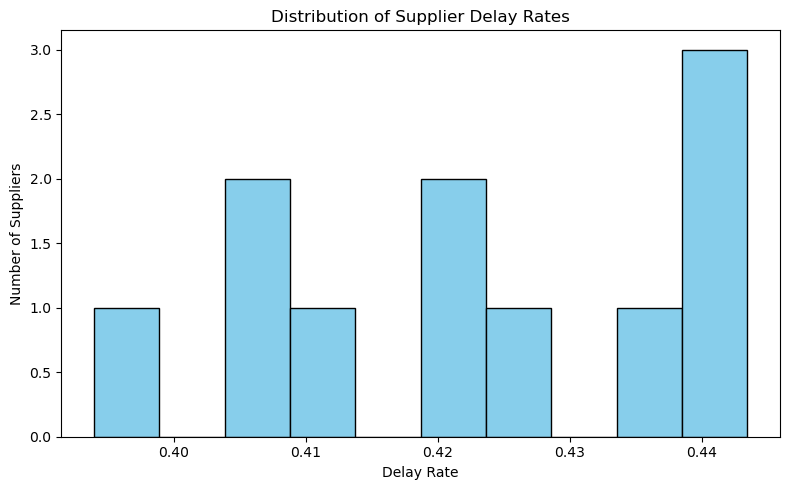

In [38]:
supplier_delay_rate = data.groupby('Supplier Name')['Arrival Status'].apply(lambda x: (x == 'Delay').mean())

plt.figure(figsize=(8, 5))
plt.hist(supplier_delay_rate, bins=10, edgecolor='black', color='skyblue')
plt.title('Distribution of Supplier Delay Rates')
plt.xlabel('Delay Rate')
plt.ylabel('Number of Suppliers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [39]:
data['Arrival Status'] = data['Arrival Status'].str.strip().str.title()

# Calculate metrics for each supplier
supplier_metrics = data.dropna(subset=['Supplier Name', 'Arrival Status']).groupby('Supplier Name').agg({
    'Arrival Status': lambda x: (x == 'Delay').mean(),  
    'Booking ID': 'count'                     
}).rename(columns={'Arrival Status': 'Delay_Rate', 'Booking ID': 'Total_Trips'})  

# Add confidence threshold - suppliers with very few trips might need different handling
min_trips_for_confidence = 5
supplier_metrics['Sufficient_Data'] = supplier_metrics['Total_Trips'] >= min_trips_for_confidence

# Classify risk levels
def classify_risk(row):
    if not row['Sufficient_Data']:
        return "Insufficient Data"  # Not enough trips to make reliable assessment
    
    rate = row['Delay_Rate']
    if pd.isna(rate):
        return "Unknown"
    elif rate > 0.43:
        return 'High'
    elif rate >= 0.40:
        return 'Medium'
    else:
        return 'Low'

supplier_metrics['Risk_Level'] = supplier_metrics.apply(classify_risk, axis=1)

In [40]:
data['Distance (KM)'][data['Distance (KM)'] >= data['Road Distance (KM)']].describe().T

count    12811.000000
mean      3077.391571
std       1714.068559
min         30.360000
25%       1785.305000
50%       2960.290000
75%       4220.780000
max      12943.920000
Name: Distance (KM), dtype: float64

In [41]:
data['Road Distance (KM)'].describe().T

count    12859.000000
mean      2951.037515
std       1640.126444
min         30.350000
25%       1706.710000
50%       2833.040000
75%       4060.940000
max      11970.930000
Name: Road Distance (KM), dtype: float64

In [42]:
"""Speed > 100 km/h → Potential data error and Speed < 20 km/h → Traffic/congestion"""
data['Avg Speed (KM/H)'] = (data['Distance (KM)'] / data['Trip Duration (Hours)']).fillna(0)
data['Avg Speed (KM/H)'] = round(data['Avg Speed (KM/H)'].apply(lambda x: 0 if x == np.Infinity else x), 2)

In [43]:
def compute_fatigue(row):
    if row['Driver Name'] == 'Unknown':
        return 'N/A'

    # Consecutive Trip Days 
    days = row['Consecutive_Driving_Days']

    if pd.isna(days):
        return 'Low'

    # Base fatigue based on days of continuous trips
    if days > 6:
        base_fatigue = 'High'
    elif days > 3:
        base_fatigue = 'Medium'
    else:
        base_fatigue = 'Low'

    # Modify fatigue based on trip type
    trip_type = row['Trip Type']
    if trip_type == 'Continuation':
        if base_fatigue == 'Low':
            return 'Medium'
        elif base_fatigue == 'Medium':
            return 'High'
    elif trip_type == 'Empty Return':
        if base_fatigue == 'High':
            return 'Medium'
        elif base_fatigue == 'Medium':
            return 'Low'

    return base_fatigue


In [44]:
# Sort data by driver and date
data = data.sort_values(['Driver Name', 'Trip Start Date'])

# Create a timeline of driving days for each driver
timeline_data = []

for driver, driver_trips in data.groupby('Driver Name'):
    if driver == 'Unknown':
        continue
        
    # Process each trip
    for _, trip in driver_trips.iterrows():
        # Get trip start and end dates
        start_date = trip['Trip Start Date']
        end_date = trip['Trip End Date']
        
        # Create a record for each day the driver was driving
        current_date = start_date
        while current_date <= end_date:
            timeline_data.append({
                'Driver Name': driver,
                'Date': current_date,
                'Trip ID': trip.name  # Store the trip ID to link back
            })
            current_date += pd.Timedelta(days=1)

# Convert to DataFrame
if timeline_data:
    timeline_df = pd.DataFrame(timeline_data)
    
    # Sort by driver and date
    timeline_df = timeline_df.sort_values(['Driver Name', 'Date'])
    
    # Mark gaps in the timeline (more than 1 day between dates)
    timeline_df['Date_Diff'] = timeline_df.groupby('Driver Name')['Date'].diff().dt.days
    timeline_df['New_Streak'] = (timeline_df['Date_Diff'] > 1) | (timeline_df['Date_Diff'].isna())
    timeline_df['Streak_Group'] = timeline_df.groupby('Driver Name')['New_Streak'].cumsum()
    
    # Count consecutive days for each streak
    streak_days = timeline_df.groupby(['Driver Name', 'Streak_Group'])['Date'].agg(['min', 'max', 'count'])
    streak_days['Consecutive_Driving_Days'] = (streak_days['max'] - streak_days['min']).dt.days + 1
    
    # Verify that count and day calculation match (they should, but good to check)
    streak_days['Matches'] = streak_days['count'] == streak_days['Consecutive_Driving_Days']
    
    # Create a mapping from trip ID to streak info
    trip_to_streak = timeline_df.merge(
        streak_days[['Consecutive_Driving_Days']], 
        left_on=['Driver Name', 'Streak_Group'],
        right_index=True
    )[['Trip ID', 'Consecutive_Driving_Days']].drop_duplicates()
    
    # Map this info back to original dataframe
    trip_mapping = trip_to_streak.set_index('Trip ID')['Consecutive_Driving_Days']
    data['Consecutive_Driving_Days'] = data.index.map(trip_mapping)
    
    # For any trips that didn't map (should be only 'Unknown' drivers), set to NaN
    data['Consecutive_Driving_Days'] = data['Consecutive_Driving_Days'].fillna(value=pd.NA)

    # Now apply the fatigue function
    data['Fatigue Risk'] = data.apply(compute_fatigue, axis=1)
else:
    # Handle the case where there's no valid data
    data['Consecutive_Driving_Days'] = pd.NA
    data['Fatigue Risk'] = 'Low'

In [45]:
data['KM_Since_Last_Service'] = data.groupby('Vehicle Registration')['Distance (KM)'].cumsum() % 32000
data['Needs_Service_Soon'] = data['KM_Since_Last_Service'] > 32000

In [46]:
for col in data.columns:
    if data[col].dtype == "object":
        print(f"====== {col} ==========")
        print(data[col].unique())
        print()

====== Booking ID ==========
['f6c1a5a1-615c-493c-993a-be28ef04fd11'
 '0f9087b4-d5e4-4abc-bfcc-e6b6a1f2505e'
 'e8f1b5df-3fe1-4899-867e-27d5c742dd77' ...
 'b9fd5dfb-eca6-4f37-9c89-71ac6dc9da9b'
 'bbc4d825-e19a-4057-ab90-ac7c8502a176'
 'cc2486a0-888c-43c1-b76b-3aa2753049cf']

====== Origin Location ==========
['Jacksonville, FL' 'Phoenix, AZ' 'Vancouver, BC' 'Mexico City'
 'San Antonio, TX' 'Cancun' 'New York, NY' 'Calgary, AB' 'Los Angeles, CA'
 'Denver, CO' 'Seattle, WA' 'Toronto, ON' 'Fort Worth, TX' 'San Jose, CA'
 'Houston, TX' 'Guadalajara' 'Charlotte, NC' 'Boston, MA' 'Chicago, IL'
 'Dallas, TX' 'Washington, DC' 'Indianapolis, IN' 'Austin, TX' 'Monterrey'
 'Tijuana' 'Montreal, QC' 'San Diego, CA' 'Philadelphia, PA'
 'Columbus, OH' 'Leon']

====== Stopover Location ==========
[nan 'Indianapolis, IN' 'Chicago, IL' 'Cancun' 'Leon' 'Houston, TX'
 'Tijuana' 'Fort Worth, TX' 'Charlotte, NC' 'New York, NY' 'Phoenix, AZ'
 'Boston, MA' 'Philadelphia, PA' 'Denver, CO' 'Vancouver, BC' 'Dalla

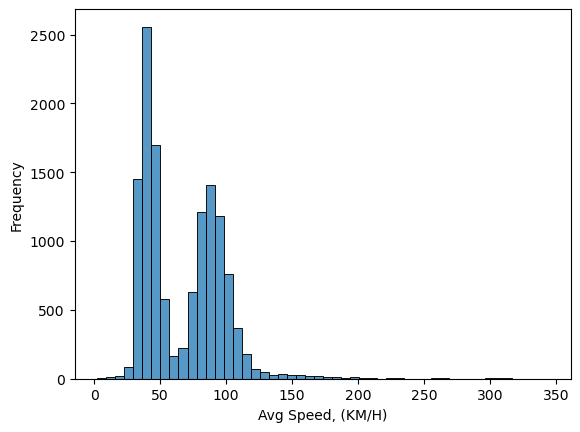

In [47]:
sns.histplot(data, x='Avg Speed (KM/H)', bins=50)
plt.xlabel("Avg Speed, (KM/H)")
plt.ylabel("Frequency")
plt.show()

We have trips with speed above the limit, of 85 mph = 136.79 Km/h, reaching 140 might be understandable but anything beyond that must be dimmed erronous

In [48]:
print(data.shape[0])
data = data[data['Avg Speed (KM/H)'] < 140]
print(data.shape[0])

12859
12676


In [49]:
data['Month'] = data['Booking Date'].dt.month_name()
data['Year'] = data['Booking Date'].dt.year

In [54]:
data = data[
    (data['Distance (KM)'] >= data['Road Distance (KM)'] * 0.98)
]


In [55]:
# save empty returns seperate to delayed, and empty return will serve as a control 
empty.to_csv("../clean data/empty_returns.csv", index=False)
delayed = data[data['Trip Type'] != 'Empty Return']
delayed.to_csv("../clean data/delayed.csv", index=False)